In [1]:
# Greenwashing Detection — Zenodo Green Claims Dataset
# Colab-ready notebook script. This notebook performs:
# 1. dataset download and inspection
# 2. preprocessing
# 3. EDA (word frequencies, wordclouds, class distribution)
# 4. baseline: TF-IDF + Logistic Regression
# 5. transformer: DistilBERT fine-tune (Hugging Face)
# 6. explainability with LIME


In [2]:
!pip install --quiet datasets transformers[torch] torch torchvision torchaudio scikit-learn lime flask-ngrok wordcloud matplotlib seaborn pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
import re
import json
import random
import joblib
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from lime.lime_text import LimeTextExplainer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


In [4]:
from google.colab import files

In [5]:
# Download the Zenodo Green Claims dataset

DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Please upload green_claims.csv file:")
files.upload()

!mv green_claims.csv /content/data/

out_path = DATA_DIR / "green_claims.csv"
if not out_path.exists():
    print("Dataset not found at /content/data/green_claims.csv. Please upload it again.")
else:
    print("Dataset uploaded successfully to", out_path)

Please upload green_claims.csv file:


Saving green_claims.csv to green_claims.csv
Dataset uploaded successfully to /content/data/green_claims.csv


In [6]:
# Load and inspect dataset

if out_path.exists():
    df = pd.read_csv(out_path)
    print("Dataset loaded. Shape:", df.shape)
    display(df.head(8))
    print("Columns:", df.columns.tolist())
else:
    data = {
        "text": [
            "Our packaging is made from recycled ocean plastic",
            "Now with 100% natural ingredients!",
            "Certified carbon neutral by XYZ cert",
            "We are eco-friendly and sustainable"
        ],
        "label": [0, 0, 1, 0]  # dummy
    }
    df = pd.DataFrame(data)
    print("Using dummy dataset (uploaded file not found).")
    display(df.head())

Dataset loaded. Shape: (773, 7)


,Unnamed: 0,id,tweet,username,domain,label_multi,label_binary
0,0,1298757190677913600,Formulated with Dragon Fruit and Passion Fruit...,arbonne,cosmetics,not_green,not_green
1,1,934482063373283328,Skin Active: how to create an effective skin c...,loreal,cosmetics,explicit_claim,green_claim
2,2,820281365761556480,"Join us tomorrow at #Mumbai #Marathon, for the...",bajajelectrical,electronics,implicit_claim,green_claim
3,3,1136347270109179904,Just CBD. Just argan. Our blend of 100% organi...,josie_maran,cosmetics,explicit_claim,green_claim
4,4,1125037437326168066,Make them do a double take with this #makeup p...,esteelauder,cosmetics,not_green,not_green
5,5,1082768600962863104,"In partnership with @AdaptiveBiotech, we're ex...",microsoft,electronics,not_green,not_green
6,6,1025003243443761153,Experience 24-karat magic with #SupremeSkin ✨ ...,esteelauder,cosmetics,not_green,not_green
7,7,1204534035667656705,"Deep hydration, enchanting fragrance, and real...",herbalessences,cosmetics,implicit_claim,green_claim


Columns: ['Unnamed: 0', 'id', 'tweet', 'username', 'domain', 'label_multi', 'label_binary']


In [7]:
df = df.rename(columns={
    'tweet': 'text',
    'label_binary': 'label'
})

In [8]:
# Basic preprocessing

def clean_text(s):
    if pd.isnull(s):
        return ""
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r"[^a-z0-9\s]", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    return s

print("Cleaning texts...")
df['text_clean'] = df['text'].apply(clean_text)
df = df[['text', 'text_clean', 'label']].dropna().reset_index(drop=True)
print(df.shape)

Cleaning texts...
(773, 3)


In [9]:
#Train/Val/Test split

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print('Train:', train_df.shape, 'Val:', val_df.shape, 'Test:', test_df.shape)

# Save processed
proc_dir = Path('/content/processed')
proc_dir.mkdir(exist_ok=True)
train_df.to_csv(proc_dir / 'train.csv', index=False)
val_df.to_csv(proc_dir / 'val.csv', index=False)
test_df.to_csv(proc_dir / 'test.csv', index=False)

Train: (618, 3) Val: (77, 3) Test: (78, 3)


/tmp/ipython-input-2687848381.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Greenwash (0)', 'Genuine (1)'])


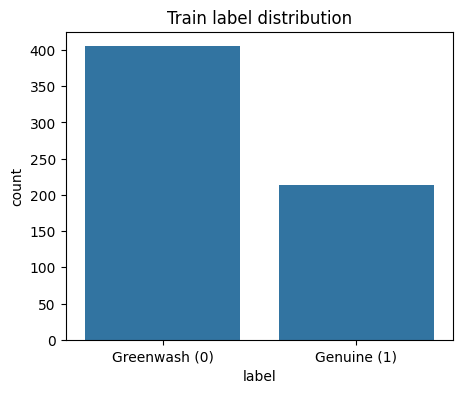

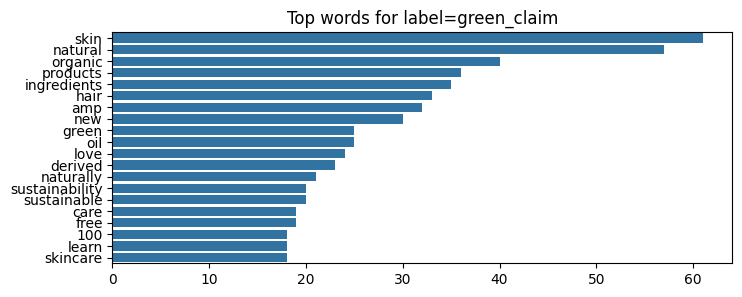

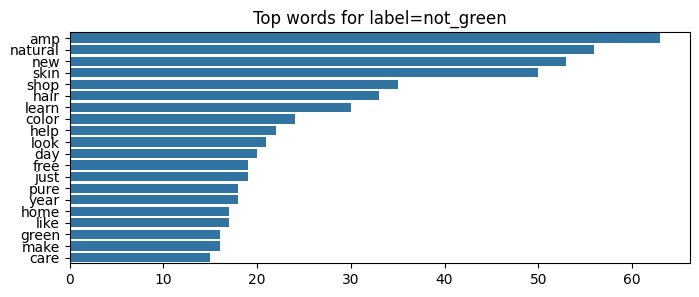

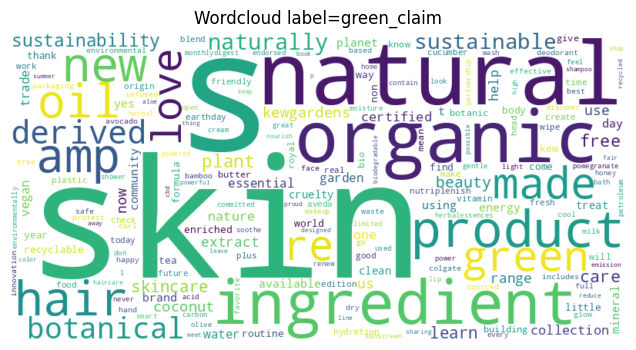

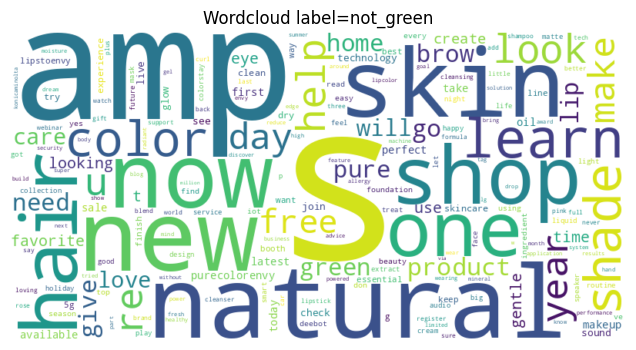

In [10]:
# EDA
plt.figure(figsize=(5,4))
ax = sns.countplot(x='label', data=train_df)
ax.set_xticklabels(['Greenwash (0)', 'Genuine (1)'])
plt.title('Train label distribution')
plt.show()

# top words per class

from sklearn.feature_extraction.text import CountVectorizer

for lbl in sorted(train_df['label'].unique()):
    texts = train_df[train_df['label'] == lbl]['text_clean']
    cv = CountVectorizer(stop_words='english', max_features=50)
    X = cv.fit_transform(texts)
    freqs = list(zip(cv.get_feature_names_out(), X.sum(axis=0).A1))
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:20]
    words, counts = zip(*freqs)
    plt.figure(figsize=(8,3))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top words for label={lbl}')
    plt.show()

# wordclouds
for lbl in sorted(train_df['label'].unique()):
    text_blob = ' '.join(train_df[train_df['label'] == lbl]['text_clean'].tolist())
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_blob)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud label={lbl}')
    plt.show()

In [12]:
# Baseline Model: TF-IDF + Logistic Regression
VEC_DIR = Path('/content/models')
VEC_DIR.mkdir(exist_ok=True)

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,3),
    stop_words='english',
    sublinear_tf=True
)

X_train = tfidf.fit_transform(train_df['text_clean'])
X_val = tfidf.transform(val_df['text_clean'])

clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    n_jobs=-1
)

clf.fit(X_train, train_df['label'])

val_preds = clf.predict(X_val)
print('Validation results (improved baseline):')
print(classification_report(val_df['label'], val_preds, target_names=['green_claim', 'not_green']))

joblib.dump(tfidf, VEC_DIR / 'tfidf_balanced.pkl')
joblib.dump(clf, VEC_DIR / 'logreg_balanced.pkl')
print('Saved improved tfidf and logreg models to /content/models')

Validation results (improved baseline):
              precision    recall  f1-score   support

 green_claim       0.70      0.78      0.74        27
   not_green       0.87      0.82      0.85        50

    accuracy                           0.81        77
   macro avg       0.79      0.80      0.79        77
weighted avg       0.81      0.81      0.81        77

Saved improved tfidf and logreg models to /content/models


In [13]:
!pip install -q --upgrade transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 11.8 MB/s eta 0:00:00


In [14]:
# Transformer Fine-tune: DistilBERT (small & fast)

MODEL_NAME = 'distilbert-base-uncased'

label_map = {label: i for i, label in enumerate(df['label'].unique())}
print("Label map:", label_map)

train_df['label'] = train_df['label'].map(label_map)
val_df['label']   = val_df['label'].map(label_map)
test_df['label']  = test_df['label'].map(label_map)

NUM_LABELS = len(df['label'].unique())

print('Preparing dataset for transformer...')

def df_to_hf(ds_df):
    ds = Dataset.from_pandas(ds_df[['text_clean','label']].rename(columns={'text_clean':'text'}))
    return ds

train_ds = df_to_hf(train_df)
val_ds = df_to_hf(val_df)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

train_ds = train_ds.remove_columns(['text'])
val_ds = val_ds.remove_columns(['text'])
train_ds.set_format(type='torch')
val_ds.set_format(type='torch')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

training_args = TrainingArguments(
    output_dir='/content/models/transformer',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy='epoch',      # 👈 old name for evaluation_strategy
    save_strategy='epoch',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    report_to='none'
)

# compute metrics
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

import os
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model('/content/models/transformer/best_model')
print('Transformer training finished and saved.')

Label map: {'not_green': 0, 'green_claim': 1}
Preparing dataset for transformer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/618 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.362038,0.844156,0.828889
2,0.458300,0.233959,0.922078,0.914444
3,0.149900,0.256795,0.922078,0.912896


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Transformer training finished and saved.


In [15]:
# Evaluate transformer on test set

from transformers import pipeline

clf_pipe = pipeline('text-classification', model='/content/models/transformer/best_model', tokenizer=tokenizer, return_all_scores=False)

texts = test_df['text_clean'].tolist()
results = clf_pipe(texts)

preds = [int(r['label'].split('_')[-1]) if isinstance(r['label'], str) and '_' in r['label'] else (1 if r['label']=='LABEL_1' or r['label']=='LABEL_1' else 0) for r in results]

print('Transformer example predictions (first 10):', preds[:10])


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Transformer example predictions (first 10): [1, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [16]:
# Explainability with LIME (baseline model)

from lime.lime_text import LimeTextExplainer

class_names = ['greenwash','genuine']
explainer = LimeTextExplainer(class_names=class_names)

# Pick a sample from test set
sample_text = test_df['text'].iloc[0]
print('Sample:', sample_text)

# Function to predict probabilities for LIME
predict_fn = lambda x: clf.predict_proba(tfidf.transform(x))

exp = explainer.explain_instance(sample_text, predict_fn, num_features=10)
print('LIME explanation:')
print(exp.as_list())

Sample: Revitalize your routine with vegan skincare and makeup products, sourced from the finest natural ingredients. From moisturizing vegan make-up made with aloe vera to vegan skincare crafted with essential oils.
LIME explanation:
[(np.str_('ingredients'), -0.07591778621640709), (np.str_('products'), -0.04960496223547431), (np.str_('vegan'), -0.04896513961638344), (np.str_('natural'), -0.040158916916818964), (np.str_('skincare'), -0.02982283170420726), (np.str_('Revitalize'), 0.01960151399890479), (np.str_('sourced'), -0.01644849374573397), (np.str_('make'), 0.01585028317602172), (np.str_('makeup'), 0.014366987223748328), (np.str_('essential'), -0.010808822587042136)]


In [17]:
#Save artifacts

joblib.dump({'tfidf': tfidf, 'logreg': clf}, '/content/models/baseline_pipeline.pkl')
print('Saved baseline pipeline to /content/models/baseline_pipeline.pkl')



Saved baseline pipeline to /content/models/baseline_pipeline.pkl


In [18]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace your_notebook.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [19]:
!pip install nbformat

In [22]:
import nbformat

input_nb = "green_washing.ipynb"
output_nb = "green_washing.ipynb"

with open(input_nb, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:
    nb.metadata.pop("widgets")

for cell in nb.cells:
    if "metadata" in cell and "widgets" in cell["metadata"]:
        cell["metadata"].pop("widgets")

with open(output_nb, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print(f"Cleaned notebook saved as {output_nb}")


FileNotFoundError: [Errno 2] No such file or directory: 'green_washing.ipynb'

In [23]:
!ls /content

data  models  processed  sample_data


In [ ]:
from google.colab import files
uploaded = files.upload()